In [1]:
import os
import torch
import numpy as np
import math
import functools
import matplotlib.pyplot as plt
from matplotlib import animation
from torch.fft import fft, ifft
import scipy.fft
from smld.models.helpers import marginal_prob_std, diffusion_coeff
from smld.signalsamplers import circulant, align
import smld.signalsamplers as samplers
from smld.models.convolutional import Convolutional
from smld.models.MLP import MLP
from smld.utils import Euler_Maruyama_sampler
from experimental_conditioner import experimental_conditioner
from score_projection import score_projector
from bispec_inversion.iterphasesync import bispec_inv_IPS_real
from bispec_inversion.nonconvopt import bispec_inv_PM_real
from em import expecmax

In [2]:
class GaussianDiffusionModel(torch.nn.Module):
    def __init__(
        self, 
        mean_vec,
        prior_sigma,
        marginal_prob_std,
    ):
        super().__init__()

        assert torch.allclose(torch.ones_like(mean_vec)*torch.mean(mean_vec), mean_vec)

        self.register_buffer("mean_vec", mean_vec)
        self.prior_sigma = prior_sigma
        self.marginal_prob_std = marginal_prob_std
    
    def forward(self, x, t):
        # print(self.marginal_prob_std(t)[:, None].item())
        return (self.mean_vec - x) / ((self.prior_sigma ** 2) + (self.marginal_prob_std(t)[:, None] ** 2))
    
    def __len__(self):
        return self.mean_vec.shape[-1]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device is \'{device}\'.")
generator = torch.Generator(device=device) 
generator.seed()

# Choose whether to save results.
save_results = True
# saveidx_list = [0]
saveidx_list = list(range(1,11))

# Choose the type of diffusion score model.
# Also set correct signal length and maximal diffusion sigma.
scoremodel_type = "learned" # "gaussian", "learned"
length = 41
diffusion_sigma = 3.0

# Conditioner parameters
use_none_cond = False
include_zero = True
use_CLT = True
use_random_power_spectrum = True
cond_start_frac = 0.

# How to obtain the true signal 
# If loaded, disregards the other two.
load_true_signal = True
use_random_true_signal = True
save_true_signal = False

# MRA parameters
MRA_sigma = 10.
M_vals = [int(10**(n/2)) for n in range(4, 13)] 
# M_vals = [1000000]

M_list = M_vals * len(saveidx_list)

# If not using random signal, set true signal.
signal_true = torch.zeros(length, device=device)
signal_true[length//8:(length//8)+length//2] += 1.
signal_true -= signal_true.mean()
# signal_true[0] = 1

# If gaussian diffusion model, set parameters.
prior_sigma = 1.
mean_true = 1.
mean_vec = mean_true * torch.ones(length, device=device)

# If learned diffusion model, set parameters.
MODEL_PATH = "./../../model_weights/smld/" 
learned_model_type = "conv" # "conv", "mlp"
hidden_layers = 8
hidden_dim = 4
embed_dim = 64
signal_sampler_type = "bell" # "hat", "loop", "mlt", "bell"
signal_scale = 3.0
signal_center = True

# Diffusion sampler parameters
model_sampler = Euler_Maruyama_sampler
diffusion_steps = 20000
diffusion_samples = 2**10
diffusion_epsilon = 1e-4
verbose = True

# Set parameters for plotting
plot_signal_samples = False
plot_modelsamples = False
plot_projection = False
show_plot = True
lines_per_plot = 8

# Set parameters for visualization of scores across diffusion time.
num_steps_plt = 200
min_diffusion_time_plt = 1e-2
ax_bound = 2
ax_pts = 20

# Set path where figs will be saved.
FIG_PATH = "./../figs/smld/" # NOT LOCATION SAFE
assert os.path.exists(FIG_PATH), "FIG_PATH must exist."
FIG_PATH += f"{length}/"
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)


Current device is 'cuda'.


In [4]:
## Score model setup
marginal_prob_std_fn = functools.partial(
    marginal_prob_std, 
    sigma=diffusion_sigma, 
    device=device,
)
diffusion_coeff_fn = functools.partial(
    diffusion_coeff, 
    sigma=diffusion_sigma, 
    device=device,
)

if scoremodel_type == "learned":
    assert os.path.exists(MODEL_PATH), "MODEL_PATH must exist."
    if learned_model_type == "mlp":
        scoremodel = MLP(
            marginal_prob_std_fn, 
            length, 
            hidden_dim, 
            hidden_layers, 
            embed_dim,
        ).to(device)
    elif learned_model_type == "conv":
        scoremodel = Convolutional(
            marginal_prob_std_fn, 
            length, 
            hidden_dim, 
            hidden_layers, 
            embed_dim,
        ).to(device)
    else:
        raise NotImplementedError(f"No learned model has type {learned_model_type}")

    model_name = "_".join((
        f"{str(scoremodel)}",
        f"len{length}",
        f"lay{hidden_layers}",
        f"hid{hidden_dim}",
        f"emb{embed_dim}",
        f"sgm{diffusion_sigma}",
        f"{signal_sampler_type}{signal_scale}",
        f"cnt{signal_center}",
    ))
    MODEL_PATH += f"{model_name}/"
    if not os.path.exists(MODEL_PATH): 
        print(f"Got an invalid {MODEL_PATH = }")
    else:
        print(f"Score model is loaded from {MODEL_PATH}")
    
    base_signal = torch.load(MODEL_PATH+"signal.pth", weights_only=True).to(device)
    if signal_sampler_type == "loop":
        signal_sampler = samplers.DegenerateLoopSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            center=signal_center,
            generator=generator, 
            device=device,
        )
    elif signal_sampler_type == "planck":
        signal_sampler = samplers.PlanckSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            center=signal_center,
            generator=generator, 
            device=device,
        )
    elif signal_sampler_type == "hat":
        signal_sampler = samplers.HatSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            center=signal_center,
            generator=generator, 
            device=device,
        )
    elif signal_sampler_type == "mlt":
        signal_sampler = samplers.MultiSampler(
        scale=signal_scale, 
        signal=base_signal, 
        length=length, 
        center=signal_center,
        generator=generator, 
        device=device,
    )
    elif signal_sampler_type == "bell":
        signal_sampler = samplers.BellSampler(
        scale=signal_scale, 
        signal=base_signal, 
        length=length, 
        center=signal_center,
        generator=generator, 
        device=device,
    )
    else: 
        raise NotImplementedError(f"No signal sampler has type {signal_sampler_type}")
    scoremodel.load_state_dict(torch.load(MODEL_PATH+"weights_dict.pth", weights_only=True))
    scoremodel.eval()
elif scoremodel_type == "gaussian":
    scoremodel = GaussianDiffusionModel(
        mean_vec=mean_vec, 
        prior_sigma=prior_sigma,
        marginal_prob_std=marginal_prob_std_fn,
    ).to(device)
    signal_sampler = samplers.GaussianSampler(
        scale=prior_sigma, 
        signal=mean_vec, 
        length=length, 
        center=signal_center,
        generator=generator, 
        device=device,
    )
else: 
    raise NotImplementedError(f"No diffusion model has unimplemented type: {scoremodel_type}")


Score model is loaded from ./../../model_weights/smld/conv_len41_lay8_hid4_emb64_sgm3.0_bell3.0_cntTrue/


In [5]:
## Generate signal samples from the true prior.
signal_samples = signal_sampler(num=diffusion_samples, do_random_shifts=True).squeeze(0)
signal_samples_pwrspec = torch.abs(fft(signal_samples, norm='ortho')).square()

print(signal_samples_pwrspec.std(dim=0)/signal_samples_pwrspec.mean(dim=0))

tensor([ 1.6855,  1.1213,  1.0838,  1.1589,  1.1385,  1.4608,  1.6726,  2.1415,
         2.9990,  4.0238,  5.4995,  6.5451,  8.1110,  9.8370, 11.8421, 14.4866,
        17.5164, 20.3154, 22.3166, 23.5067, 24.0684, 24.0684, 23.5067, 22.3166,
        20.3154, 17.5164, 14.4866, 11.8421,  9.8370,  8.1110,  6.5451,  5.4995,
         4.0238,  2.9990,  2.1415,  1.6726,  1.4608,  1.1385,  1.1589,  1.0838,
         1.1213], device='cuda:0')


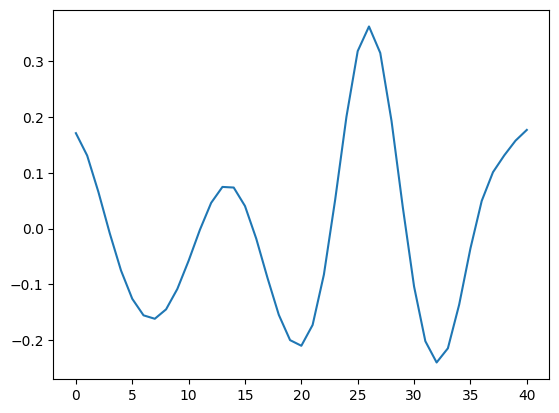

In [ ]:
## Set the true signal for MRA.
if load_true_signal:
    signal_true = torch.load(MODEL_PATH+"signal_example.pt", weights_only=True).to(device)
else:
    if use_random_true_signal:
        signal_true = signal_sampler(do_random_shifts=False).squeeze(0)
    else:
        signal_true = signal_true
    if save_true_signal:
        torch.save(signal_true+signal_sampler.signal_mean, MODEL_PATH+"signal_example.pt")

plt.plot(signal_true.cpu())
plt.show()

In [7]:
## Circulant of the true signal and MRA statistics are derived.
circulant_true = circulant(signal_true, dim=0)
power_spectrum_true = torch.abs(fft(signal_true, norm='ortho')).square()

In [8]:
## Generate MRA samples.
MRA_sampler = samplers.GaussianSampler(
    scale=MRA_sigma, 
    signal=signal_true, 
    length=length,
    center=False,
    generator=generator, 
    device=device,
)

MRA_samples_list = []
power_spectrum_sample_list = []
power_spectrum_est_list = []
for idx, M in enumerate(M_list):
    MRA_samples_list.append(MRA_sampler(num=M, do_random_shifts=True))

    if use_random_power_spectrum:
        power_spectrum_sample_list.append(
            torch.abs(
                fft(MRA_samples_list[idx], norm='ortho')
            ).square().mean(dim=0)
        )
    else:
        power_spectrum_sample_list.append(power_spectrum_true + (MRA_sigma ** 2))
    power_spectrum_est_list.append(power_spectrum_sample_list[idx] - (MRA_sigma ** 2))
    power_spectrum_est_list[idx][power_spectrum_est_list[idx]<0.] = 0.

In [9]:
## Conditioner setup
even = True if length%2 == 0 else False
# print("even is " + str(even))

conditioner_list = []
for idx, M in enumerate(M_list):
    if use_none_cond:
        conditioner_list.append(None)
    else:
        conditioner_list.append(
            functools.partial(
                experimental_conditioner,
                marginal_prob_std=marginal_prob_std_fn,
                rho_est=power_spectrum_est_list[idx],
                M=M,
                MRA_sigma=MRA_sigma,
                even=even,
                include_zero=include_zero,
                use_CLT=use_CLT,
                device=device,
            )
        )

In [10]:
## Generate diffusion samples
model_samples_list = []
for idx, M in enumerate(M_list):
    print(idx)
    print(M)
    model_samples_list.append(
        model_sampler(
            scoremodel=scoremodel, 
            marginal_prob_std=marginal_prob_std_fn,
            diffusion_coeff=diffusion_coeff_fn,
            length=length,
            batch_size=diffusion_samples,
            num_steps=diffusion_steps,
            eps=diffusion_epsilon,
            conditioner=conditioner_list[idx],
            cond_start_frac=cond_start_frac,
            verbose=verbose,
            device=device,
        )
    )
    if torch.any(torch.isinf(model_samples_list[-1])) or torch.any(torch.isnan(model_samples_list[-1])):
        raise TypeError("GOT INF OR NAN")

0
100
Diffusion step:      0/20000
Diffusion step:    200/20000
Diffusion step:    400/20000
Diffusion step:    600/20000
Diffusion step:    800/20000
Diffusion step:   1000/20000
Diffusion step:   1200/20000
Diffusion step:   1400/20000
Diffusion step:   1600/20000
Diffusion step:   1800/20000
Diffusion step:   2000/20000
Diffusion step:   2200/20000
Diffusion step:   2400/20000
Diffusion step:   2600/20000
Diffusion step:   2800/20000
Diffusion step:   3000/20000
Diffusion step:   3200/20000
Diffusion step:   3400/20000
Diffusion step:   3600/20000
Diffusion step:   3800/20000
Diffusion step:   4000/20000
Diffusion step:   4200/20000
Diffusion step:   4400/20000
Diffusion step:   4600/20000
Diffusion step:   4800/20000
Diffusion step:   5000/20000
Diffusion step:   5200/20000
Diffusion step:   5400/20000
Diffusion step:   5600/20000
Diffusion step:   5800/20000
Diffusion step:   6000/20000
Diffusion step:   6200/20000
Diffusion step:   6400/20000
Diffusion step:   6600/20000
Diffusio

In [11]:
## Do bispectrum inversion
def phase_sync(vec_est, vec_true):
    min_diff = np.linalg.norm(vec_true - vec_est)/np.linalg.norm(vec_true)
    min_ind = 0
    for i in range(len(vec_true)):
        if min_diff > np.linalg.norm(vec_true - np.roll(vec_est, i))/np.linalg.norm(vec_true):
            min_diff = np.linalg.norm(vec_true - np.roll(vec_est, i))/np.linalg.norm(vec_true)
            min_ind = i
    return np.roll(vec_est, min_ind), min_diff

# Compute spectra using numpy, legacy issues due to non-unitary dft.
bispectrum_sample_list = []
power_spectrum_est_np_list = []
signal_aligned_IPS_list = []
signal_aligned_OPM_list = []
for idx, M in enumerate(M_list):
    print(idx)
    print(M)
    data_fft = scipy.fft.fft(
        (MRA_samples_list[idx] - MRA_samples_list[idx].mean(dim=0)).numpy(force=True)
    )
    circulant_data_fft = samplers.circulant(torch.from_numpy(data_fft), dim=-1).numpy(force=True)
    bispectrum_sample_list.append(
        np.mean(
            (np.einsum('mij, mij -> mij', np.einsum('mi, mj -> mij', data_fft, np.conj(data_fft)), circulant_data_fft)),
            axis=0,
        )
    )
    power_spectrum_est_np_list.append(np.mean(np.square(np.abs(data_fft)), axis=0) - length*(MRA_sigma ** 2))
    power_spectrum_est_np_list[idx][power_spectrum_est_np_list[idx] < 0.] = 0.

    phases_est_IPS = bispec_inv_IPS_real(bispectrum_sample_list[idx], maxiter=1000)
    fft_est_IPS = np.sqrt(power_spectrum_est_np_list[idx]) * phases_est_IPS
    signal_IPS = scipy.fft.ifft(fft_est_IPS).real + MRA_samples_list[idx].mean(dim=0).numpy(force=True)
    signal_aligned_IPS, min_diff = phase_sync(signal_IPS, signal_true.numpy(force=True))
    signal_aligned_IPS_list.append(signal_aligned_IPS)

    phases_est_OPM = bispec_inv_PM_real(bispectrum_sample_list[idx])
    fft_est_OPM = np.sqrt(power_spectrum_est_np_list[idx]) * phases_est_OPM
    signal_OPM = scipy.fft.ifft(fft_est_OPM).real + MRA_samples_list[idx].mean(dim=0).numpy(force=True)
    signal_aligned_OPM, min_diff = phase_sync(signal_OPM, signal_true.numpy(force=True))
    signal_aligned_OPM_list.append(signal_aligned_OPM)

0
100
1
316
2
1000
3
3162
4
10000
5
31622
6
100000
7
316227
8
1000000
9
100
10
316
11
1000
12
3162
13
10000
14
31622
15
100000
16
316227
17
1000000
18
100
19
316
20
1000
21
3162
22
10000
23
31622
24
100000
25
316227
26
1000000
27
100
28
316
29
1000
30
3162
31
10000
32
31622
33
100000
34
316227
35
1000000
36
100
37
316
38
1000
39
3162
40
10000
41
31622
42
100000
43
316227
44
1000000
45
100
46
316
47
1000
48
3162
49
10000
50
31622
51
100000
52
316227
53
1000000
54
100
55
316
56
1000
57
3162
58
10000
59
31622
60
100000
61
316227
62
1000000
63
100
64
316
65
1000
66
3162
67
10000
68
31622
69
100000
70
316227
71
1000000
72
100
73
316
74
1000
75
3162
76
10000
77
31622
78
100000
79
316227
80
1000000
81
100
82
316
83
1000
84
3162
85
10000
86
31622
87
100000
88
316227
89
1000000


In [ ]:
# Do expectation maximization
signal_aligned_EM_list = []
for idx, M in enumerate(M_list):
    print(idx)
    print(M)
    init_guess = torch.std(MRA_samples_list[idx]) * torch.randn_like(signal_true, device=device)
    signal_aligned_EM_list.append(
        expecmax(
            X=MRA_samples_list[idx],
            sigma=MRA_sigma,
            x0=init_guess,
            device=device,
            generator=generator,
        )
    )

0
100


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
aligned_samples_list = [] 
aligned_posterior_est_list = []
for idx, M in enumerate(M_list):
    print(M)
    best_candidate = None
    min_armsd = torch.tensor(1e8).to(device)
    for candidate in model_samples_list[idx]:
        # tmp_aligned_samples_list = []
        tmp_armsd_list = []
        candidate_circulant = circulant(candidate, dim=-1)
        for sample in model_samples_list[idx]:
            # tmp_aligned_samples_list.append(align(sample, candidate))
            tmp_armsd_list.append(
                (
                    sample[None, :] - candidate_circulant
                ).square().mean(dim=-1).sqrt().min(dim=-1)[0].unsqueeze(0)
            )
        avg_armsd = torch.cat(tmp_armsd_list).mean()
        if avg_armsd < min_armsd:
            min_armsd = avg_armsd
            best_candidate = candidate
    aligned_posterior_est_list.append(align(best_candidate, signal_true))
    aligned_samples_list.append(align(model_samples_list[idx], signal_true))
    
    # aligned_posterior_mean_list.append(aligned_samples_list[idx].mean(dim=0))
    # num_nan = 0
    # for sample in model_samples_list[idx]:
    #     for comp in sample:
    #         if torch.isnan(comp):
    #             num_nan += 1
    #             break
    # print(num_nan)


In [ ]:
## Print metrics

# print(model_samples.std().item())

outputs_power_spectrum_rmsd = (
    torch.abs(fft(model_samples_list[-1], norm='ortho')).square() - power_spectrum_true
).square().mean(dim=-1).sqrt()

print(
    "Average RMSD between sample power spectra and the true power spectrum is: ", 
    f"{outputs_power_spectrum_rmsd.mean().item():.2f}",
)

outputs_rmsd = (
    model_samples_list[-1].unsqueeze(1) - circulant_true
).square().mean(dim=-1).sqrt().min(dim=-1)[0]

print(
    "Average RMSD between model samples and the true signal is: ", 
    f"{outputs_rmsd.mean().item():.2f}",
)

# outputs_mean_signs = torch.sign(model_samples.mean(dim=-1))
# pos_perc_model = 100. * (torch.sum(outputs_mean_signs + 1) // 2) / diffusion_samples
# signal_mean_signs = torch.sign(signal_samples.mean(dim=-1))
# pos_perc_signal = 100. * (torch.sum(signal_mean_signs + 1) // 2) / diffusion_samples

# print(f"Percentage of positive means among model samples: {pos_perc_model:.2f}%")
# print(f"Percentage of positive means among signal samples: {pos_perc_signal:.2f}%")

posterior_est_rmsd_list = []
signal_IPS_rmsd_list = []
signal_OPM_rmsd_list = []
signal_EM_rmsd_list = []
for idx, M in enumerate(M_list):
    posterior_est_rmsd_list.append(
        (
            aligned_posterior_est_list[idx].unsqueeze(0) - circulant_true
        ).square().mean(dim=-1).sqrt().min(dim=-1)[0].cpu()
    )
    signal_IPS_rmsd_list.append(
        (
            torch.from_numpy(signal_aligned_IPS_list[idx].real).to(device).unsqueeze(0) - circulant_true
        ).square().mean(dim=-1).sqrt().min(dim=-1)[0].cpu()
    )
    signal_OPM_rmsd_list.append(
        (
            torch.from_numpy(signal_aligned_OPM_list[idx].real).to(device).unsqueeze(0) - circulant_true
        ).square().mean(dim=-1).sqrt().min(dim=-1)[0].cpu()
    )
    signal_EM_rmsd_list.append(
        (
            signal_aligned_EM_list[idx].to(device).unsqueeze(0) - circulant_true
        ).square().mean(dim=-1).sqrt().min(dim=-1)[0].cpu()
    )

print(
    "aRMSD between the final posterior estimate and the true signal is: ", 
    f"{posterior_est_rmsd_list[-1].mean().item():.2f}",
)
print(
    "aRMSD between the final IPS inversion and the true signal is: ", 
    f"{signal_IPS_rmsd_list[-1].mean().item():.2f}",
)
print(
    "aRMSD between the final OPM inversion and the true signal is: ", 
    f"{signal_OPM_rmsd_list[-1].mean().item():.2f}",
)
print(
    "aRMSD between the final EM estimate and the true signal is: ", 
    f"{signal_EM_rmsd_list[-1].mean().item():.2f}",
)

In [ ]:
plt.plot(signal_true.cpu())
plt.plot(aligned_posterior_est_list[-1].cpu())
plt.show()

In [ ]:
## Visualization

# Hyperparameters for plotting
plot_fontsize = 21
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times",
})
plane_mag = signal_true.mean().item()
# plt.rcParams.update({
#     "text.usetex": False,
# })


In [ ]:

# Plot samples from diffusion sampler. ONLY FOR length = 3.
if length == 3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.scatter(
    #     [0.],
    #     [0.],
    #     [0.],
    #     c='black',
    #     marker = 'x',
    # )
    ax.scatter(
        model_samples_list[-1][:, 0].to('cpu'), 
        model_samples_list[-1][:, 1].to('cpu'), 
        model_samples_list[-1][:, 2].to('cpu'), 
        c='b',
        marker='.',
        label='Model samples',
    )
    ax.scatter(
        circulant_true[:, 0].to('cpu'), 
        circulant_true[:, 1].to('cpu'), 
        circulant_true[:, 2].to('cpu'), 
        c='r',
        marker='*',
        linewidth=4.,
        label='True signal',
    )
    theta = np.linspace(0, 2 * np.pi, 100)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    if radius > 1e-5:
        phi = -np.pi/4
        xyz = np.stack(
            [
                radius * np.sin(theta) * np.cos(phi),
                radius * np.sin(theta) * np.sin(phi),
                radius * np.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = np.array(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ]
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = rotmat @ xyz
        xyz1 = xyz + signal_true[0:3].mean().item()
        xyz2 = xyz - signal_true[0:3].mean().item()
        ax.plot(xyz1[0, ...], xyz1[1, ...], xyz1[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.plot(xyz2[0, ...], xyz2[1, ...], xyz2[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        legend_list = ['Model samples', 'True signal', 'Phase manifold']
    else:
        legend_list = ['Model samples', 'True signal']
    ax.legend(legend_list)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'model_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'model_samples_top.png')


In [ ]:
# Plot samples from signal sampler. ONLY FOR length = 3.
if length == 3 and plot_signal_samples:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    ax.scatter(
        signal_samples[:, 0].to('cpu'), 
        signal_samples[:, 1].to('cpu'), 
        signal_samples[:, 2].to('cpu'), 
        c='g',
        marker='.',
        label='Signal samples',
    )
    # if conditioner != None:
    #     ax.scatter(
    #         signal_true[0].to('cpu'), 
    #         signal_true[1].to('cpu'), 
    #         signal_true[2].to('cpu'), 
    #         c='r',
    #         marker='*',
    #         linewidth=4.,
    #         label='True signal',
    #     )
    #     ax.legend(['Origin', 'Signal samples', 'True signal'])
    # else:
    ax.legend(['Origin', 'Signal samples'])
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'signal_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'signal_samples_top.png')


In [ ]:

# Plot signal and model samples. ONLY FOR length = 3.
if length == 3 and plot_signal_samples:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    ax.scatter(
        signal_samples[:, 0].to('cpu'), 
        signal_samples[:, 1].to('cpu'), 
        signal_samples[:, 2].to('cpu'), 
        c='g', 
        marker='.',
        label='Signal samples',
    )
    ax.scatter(
        model_samples_list[-1][:, 0].to('cpu'), 
        model_samples_list[-1][:, 1].to('cpu'), 
        model_samples_list[-1][:, 2].to('cpu'), 
        c='b', 
        marker='.',
        label='Model samples',
    )
    ax.scatter(
        circulant_true[:, 0].to('cpu'), 
        circulant_true[:, 1].to('cpu'), 
        circulant_true[:, 2].to('cpu'), 
        c='r',
        marker='*',
        linewidth=4.,
        label='True signal',
    )
    theta = np.linspace(0, 2 * np.pi, 100)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    if radius > 1e-5:
        phi = -np.pi/4
        xyz = np.stack(
            [
                radius * np.sin(theta) * np.cos(phi),
                radius * np.sin(theta) * np.sin(phi),
                radius * np.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = np.array(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ]
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = rotmat @ xyz
        xyz1 = xyz + signal_true[0:3].mean().item()
        xyz2 = xyz - signal_true[0:3].mean().item()
        ax.plot(xyz1[0, ...], xyz1[1, ...], xyz1[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.plot(xyz2[0, ...], xyz2[1, ...], xyz2[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.legend(['Origin', 'Signal samples', 'Model samples', 'True signal', 'Phase manifold'])
    else: 
        ax.legend(['Origin', 'Signal samples', 'Model samples', 'True signal'])
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'all_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'all_samples_top.png')


In [ ]:

# Project unconditional scores in plane containing true signal.
# ONLY FOR length = 3
if length == 3 and plot_projection:
    F1 = functools.partial(
        score_projector, 
        scoremodel=scoremodel, 
        conditioner=None,
        plane_mag=plane_mag, 
        ax_bound=ax_bound,
        ax_pts=ax_pts,
        device=device,
    )

    S1, XY1, P1 = F1(min_diffusion_time_plt)
    XY1 = XY1.to('cpu')
    S1 = S1.to('cpu')

    fig, ax = plt.subplots()
    Q1 = ax.quiver(
        XY1[:, :, 0], 
        XY1[:, :, 1], 
        S1[:, :, 0], 
        S1[:, :, 1],
    )
    ax.set_aspect('equal', 'box')
    centers1 = plt.scatter(
        (P1 @ circulant(signal_true[:3], 0)).to('cpu')[0, :], 
        (P1 @ circulant(signal_true[:3], 0)).to('cpu')[1, :],
        c='r',
        marker='*',
        linewidth=4.,
    ) 
    theta = torch.linspace(0, 2 * np.pi, 100, device=device)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    phi = -np.pi/4
    xyz = torch.stack(
        [
            radius * torch.sin(theta) * np.cos(phi),
            radius * torch.sin(theta) * np.sin(phi),
            radius * torch.cos(theta),
        ],
        axis=0,
    ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
    rotmat = torch.tensor(
        [
            [0.9082704, -0.0917296, -0.4082040],
            [-0.0917296, 0.9082704, -0.4082040],
            [0.4082040, 0.4082040, 0.8165408],
        ],
        device=device,
    ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
    xyz = P1 @ ((rotmat @ xyz) + plane_mag)
    phase_manifold1 = plt.plot(xyz.to('cpu')[0, ...], xyz.to('cpu')[1, ...], c='red', linestyle='dotted', linewidth=1.5)

    plt.title(f"2D projection of unconditional scores at diffusion time {min_diffusion_time_plt}")
    fig.tight_layout()
    plt.savefig(FIG_PATH + 'unconditional_scores.png')

    # If conditioner is used, project conditional scores in plane containing true signal.
    if not use_none_cond:
        F2 = functools.partial(
            score_projector, 
            scoremodel=scoremodel, 
            conditioner=conditioner_list[-1],
            plane_mag=plane_mag, 
            ax_bound=ax_bound,
            ax_pts=ax_pts,
            device=device,
        )

        S2, XY2, P2 = F2(min_diffusion_time_plt)
        XY2 = XY2.to('cpu')
        S2 = S2.to('cpu')

        fig, ax = plt.subplots()

        Q2 = ax.quiver(
            XY2[:, :, 0], 
            XY2[:, :, 1], 
            S2[:, :, 0], 
            S2[:, :, 1],
        )
        ax.set_aspect('equal', 'box')
        centers = ax.scatter(
            (P2 @ circulant(signal_true[:3], 0)).to('cpu')[0, :], 
            (P2 @ circulant(signal_true[:3], 0)).to('cpu')[1, :],
            c='r',
            marker='*',
            linewidth=4.,
        ) 
        theta = torch.linspace(0, 2 * np.pi, 100, device=device)
        radius = torch.norm(signal_true - signal_true.mean()).item()
        phi = -np.pi/4
        xyz = torch.stack(
            [
                radius * torch.sin(theta) * np.cos(phi),
                radius * torch.sin(theta) * np.sin(phi),
                radius * torch.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = torch.tensor(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ],
            device=device,
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = P2 @ ((rotmat @ xyz) + plane_mag)
        phase_manifold2 = plt.plot(xyz.to('cpu')[0, ...], xyz.to('cpu')[1, ...], c='red', linestyle='dotted', linewidth=1.5)

        plt.title(f"2D projection of conditional scores at diffusion time {min_diffusion_time_plt}")
        fig.tight_layout()
        plt.savefig(FIG_PATH + 'conditional_scores.png')

In [ ]:
if length > 3:
    if plot_signal_samples:
        fig_s, ax_s = plt.subplots()
        ax_s.plot(signal_true.to('cpu'), c='k', linewidth=1.5, zorder=2,)
        ax_s.plot(signal_samples[:lines_per_plot].to('cpu').T, zorder=2,)
        ax_s.legend(
            ["True signal"],
            fontsize=plot_fontsize, 
            loc='upper right',
        )
        # plt.title(f"Samples of true signal distribution")
        ax_s.set_xlim(-0.5, 40.5)
        ax_s.set_ylim(-2.75, 2.75)
        ax_s.set_xticks(range(0, 41, 10))
        ax_s.set_xticks(range(41), minor=True)
        yticks_s = [-2, -1, 0, 1, 2]
        ax_s.set_yticks(yticks_s)
        ax_s.set_xticklabels(
            range(0, 41, 10),
            fontsize=plot_fontsize,
        )
        ax_s.set_yticklabels(
            yticks_s, 
            fontsize=plot_fontsize,
            # verticalalignment='baseline',
            # horizontalalignment='left',
        )
        ax_s.set_aspect(10.)
        fig_s.tight_layout()
        plt.savefig(FIG_PATH + 'signal_samples.png')
        plt.savefig(FIG_PATH + 'signal_samples.pdf')

    roll_num = 0
    fig_c, ax_c = plt.subplots()
    ax_c.plot(
        signal_true.cpu().roll(roll_num), 
        c='k', 
        linewidth=1.5,
        zorder=2,
    )
    ax_c.plot(
        np.roll(signal_aligned_IPS_list[-1], roll_num), 
        c='m', 
        linestyle="dashdot", 
        linewidth=1.5, 
        zorder=2,
    )
    ax_c.plot(
        np.roll(signal_aligned_OPM_list[-1], roll_num), 
        c='b', 
        linestyle="dashdot", 
        linewidth=1.5, 
        zorder=2,
    )
    ax_c.plot(
        signal_aligned_EM_list[-1].cpu().roll(roll_num), 
        color='coral',
        linestyle="dashed", 
        linewidth=1.5,
        zorder=1,
    )
    ax_c.plot(
        aligned_posterior_est_list[-1].cpu().roll(roll_num), 
        color='g',
        linestyle="dashed", 
        linewidth=1.5,
        zorder=1,
    )
    
    ax_c.legend(
        ["True", "IPS", "OPM", "EM", "MBPS"],
        fontsize=plot_fontsize, 
        loc='upper right', 
        # bbox_to_anchor=(1.02, 1.05, 0, 0),
        # handlelength=1.15,
    )
    ax_c.set_xlim(-0.5, 40.5)
    ax_c.set_ylim(-1.75, 2.15)
    ax_c.set_xticks(range(0, 41, 10))
    ax_c.set_xticks(range(41), minor=True)
    yticks_c = [-1, 0, 1, 2]
    ax_c.set_yticks(yticks_c)
    # ax_m.set_yticks(np.arange(-0.4, 1.4, 0.2), minor=True)
    ax_c.set_xticklabels(
        range(0, 41, 10),
        fontsize=plot_fontsize,
    )
    ax_c.set_yticklabels(
        yticks_c, 
        fontsize=plot_fontsize,
        # verticalalignment='baseline',
        # horizontalalignment='left',
    )
    ax_c.set_aspect(10.)
    fig_c.tight_layout()
    if use_none_cond:
        # plt.title(f"Prior samples aligned with true signal")
        plt.savefig(FIG_PATH + f'prior_mean_vs_bispecinv_{signal_sampler_type}.png')
        plt.savefig(FIG_PATH + f'prior_mean_vs_bispecinv_{signal_sampler_type}.pdf')
    else:
        # plt.title(f"Posterior samples aligned with true signal")
        plt.savefig(FIG_PATH + f'posterior_mean_vs_bispecinv_{signal_sampler_type}.png')
        plt.savefig(FIG_PATH + f'posterior_mean_vs_bispecinv_{signal_sampler_type}.pdf')

    if plot_modelsamples:
        colors = ["darkgreen", "forestgreen", "mediumaquamarine", "deepskyblue", "olive", "limegreen", "blue", "teal"]
        for plot_idx in range(min(diffusion_samples//lines_per_plot, 16)):
            fig_m, ax_m = plt.subplots()
            ax_m.plot(
                signal_true.to('cpu'), 
                c='r', 
                linestyle="dashed", 
                linewidth=1.5,
                zorder=2,
            )
            # ax_m.plot(
            #     signal_aligned_IPS, 
            #     'p:', 
            #     linewidth=2, 
            #     zorder=2,
            # )
            for idx, sample in enumerate(aligned_samples_list[-1][lines_per_plot*plot_idx:lines_per_plot*(plot_idx+1), :].to('cpu')):
                ax_m.plot(
                    sample, 
                    color=colors[idx],
                    linewidth=1.5,
                    zorder=1,
                )
            ax_m.legend(
                ["True signal"], #, "Bispectrum inversion IPS"],
                fontsize=plot_fontsize, 
                loc='upper right', 
                bbox_to_anchor=(1.02, 1.05, 0, 0),
                handlelength=1.15,
            )
            ax_m.set_xlim(-0.5, 40.5)
            ax_m.set_ylim(signal_true.cpu().min()-0.45, signal_true.cpu().max()+0.45)
            ax_m.set_xticks(range(0, 41, 10))
            ax_m.set_xticks(range(41), minor=True)
            ax_m.set_yticks([-1, 0, 1])
            # ax_m.set_yticks(np.arange(-0.4, 1.4, 0.2), minor=True)
            ax_m.set_xticklabels(
                range(0, 41, 10),
                fontsize=plot_fontsize,
            )
            ax_m.set_yticklabels(
                [-1, 0, 1], 
                fontsize=plot_fontsize,
                # verticalalignment='baseline',
                # horizontalalignment='left',
            )
            ax_m.set_aspect(10.)
            fig_m.tight_layout()
            if use_none_cond:
                # plt.title(f"Prior samples aligned with true signal")
                plt.savefig(FIG_PATH + f'prior_samples_{plot_idx}.png')
                plt.savefig(FIG_PATH + f'prior_samples_{plot_idx}.pdf')
            else:
                # plt.title(f"Posterior samples aligned with true signal")
                plt.savefig(FIG_PATH + f'posterior_samples_{plot_idx}.png')
                plt.savefig(FIG_PATH + f'posterior_samples_{plot_idx}.pdf')

In [ ]:
# def update_quiver(n, T, Q, X, Y, F):
#     S_n, _, _ = F(T[n-1])
#     U_n = S_n[:, :, 0].to('cpu')
#     V_n = S_n[:, :, 1].to('cpu')
#     Q.set_UVC(U_n,V_n)
#     return Q

# timesteps = torch.linspace(1., min_diffusion_time_plt, num_steps_plt)
# anim = animation.FuncAnimation(
#     fig, 
#     update_quiver, 
#     fargs=(timesteps, Q, XY[:, :, 0], XY[:, :, 1], F), 
#     frames=num_steps_plt, 
#     interval=100,
#     blit=False,
# )

# plt.title(f"Projection of 3D-scores for diffusion time")
# anim.save('./../figs/smld/diffusion_scores.mp4')

In [ ]:
if len(M_vals) > 1:
    fig_l, ax_l = plt.subplots()
    ax_l.loglog(M_list, signal_IPS_rmsd_list)
    ax_l.loglog(M_list, signal_OPM_rmsd_list)
    ax_l.loglog(M_list, signal_EM_rmsd_list)
    ax_l.loglog(M_list, posterior_est_rmsd_list)
    ax_l.legend(
        ["IPS", "OPM", "EM", "MBPS"],
        fontsize=plot_fontsize, 
        loc='upper right', 
        # bbox_to_anchor=(1.02, 1.05, 0, 0),
        # handlelength=1.15,
    )
    fig_l.tight_layout()
    plt.savefig(FIG_PATH + f'errloglog_{signal_sampler_type}.png')
    plt.savefig(FIG_PATH + f'errloglog_{signal_sampler_type}.pdf')

In [ ]:
if save_results:
    for idx, saveidx in enumerate(saveidx_list):
        for jdx, M in enumerate(M_vals):
            SAVE_PATH = MODEL_PATH+f"runs/{signal_sampler_type}_2/{M}_samples/run_{saveidx}/"
            if not os.path.exists(SAVE_PATH):
                os.makedirs(SAVE_PATH)
            torch.save(
                aligned_posterior_est_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"aligned_posterior_est_list.pt",
            )
            torch.save(
                torch.from_numpy(signal_aligned_IPS_list[idx*len(M_vals)+jdx]), 
                SAVE_PATH+"signal_aligned_IPS_list.pt",
            )
            torch.save(
                torch.from_numpy(signal_aligned_OPM_list[idx*len(M_vals)+jdx]), 
                SAVE_PATH+"signal_aligned_OPM_list.pt",
            )
            torch.save(
                signal_aligned_EM_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"signal_aligned_EM_list.pt",
            )
            torch.save(
                posterior_est_rmsd_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"posterior_est_rmsd_list.pt",
            )
            torch.save(
                signal_IPS_rmsd_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"signal_IPS_rmsd_list.pt",
            )
            torch.save(
                signal_OPM_rmsd_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"signal_OPM_rmsd_list.pt",
            )
            torch.save(
                signal_EM_rmsd_list[idx*len(M_vals)+jdx], 
                SAVE_PATH+"signal_EM_rmsd_list.pt",
            )

In [ ]:
print(len(M_vals))